In [1]:
import matplotlib.pyplot as plt
import numpy as np
from obspy.core.trace import Trace, Stats
from obspy.core.stream import Stream
from obspy import UTCDateTime
import obspy
from obspy.clients.fdsn import Client

client = Client("IRIS")

In [2]:
#waveform functions to make importing data easier
def waveforms(start, end, adjtime):
    st = client.get_waveforms("XB", "ELYSE", "02", "B*", start-adjtime, end+adjtime)
    st.detrend(type='simple')
    return st

def uvw2enz(st):
    if len(st) != 3:
       print('Stream does not contain 3 Traces')
       return st
    for trace in st:
        head = trace.stats
        channel = head.channel
        if channel == 'BHU': U = trace.data
        elif channel == 'BHV': V = trace.data
        elif channel == 'BHW': W = trace.data
        else:
            print('Trace.channel is not BHU, BHV, or BHW')
            return st

    d = np.radians(-30)
    aU = np.radians(135)
    aV = np.radians(15)
    aW = np.radians(255)

    A = np.array([[np.cos(d)*np.sin(aU),np.cos(d)*np.cos(aU),-np.sin(d)],
                  [np.cos(d)*np.sin(aV), np.cos(d)*np.cos(aV), -np.sin(d)],
                  [np.cos(d)*np.sin(aW), np.cos(d)*np.cos(aW), -np.sin(d)]])

    B = np.linalg.inv(A)
    E,N,Z = np.dot(B,(U,V,W))

    head.channel = 'BHE'; trE = Trace(data=E, header=head)
    head.channel = 'BHN'; trN = Trace(data=N, header=head)
    head.channel = 'BHZ'; trZ = Trace(data=Z, header=head)
    stENZ = Stream(traces=[trE,trN,trZ])

    return stENZ

In [3]:
#import data from S0235b
scale = 1/200
begin = UTCDateTime('2019-07-26T12:19:19')  # p-wave arrival
end = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

for tr in st_z12:
    head = tr.stats
    channel = head.channel
    data = open('data/S0235b_' + channel + '.txt', 'w')
        
    for row in tr.data:
        data.write(str(row) + '\n')
            
    data.close()

#read in data
datZ = scale*np.array(np.loadtxt('data/S0235b_BHZ.txt'))
datE = scale*np.array(np.loadtxt('data/S0235b_BHE.txt'))
datN = scale*np.array(np.loadtxt('data/S0235b_BHN.txt'))

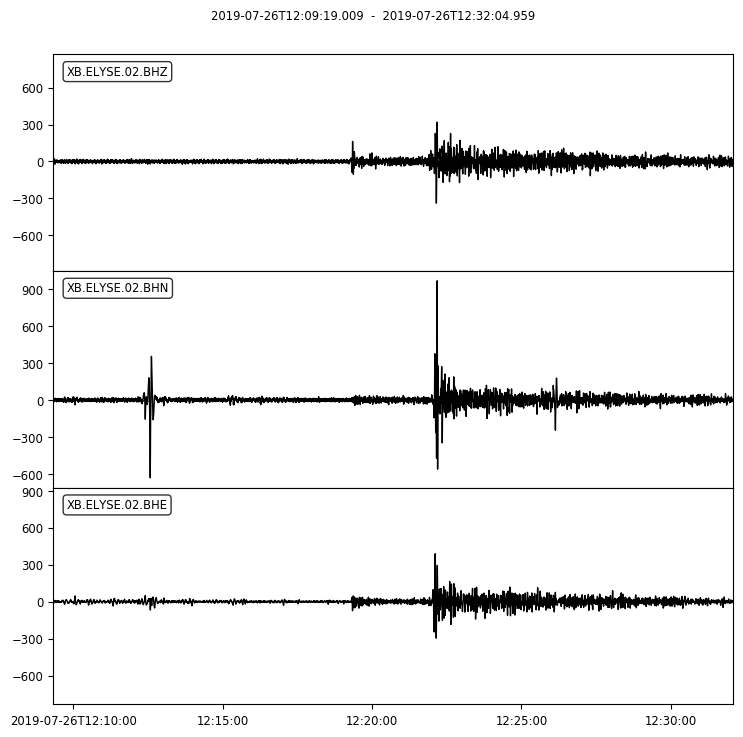

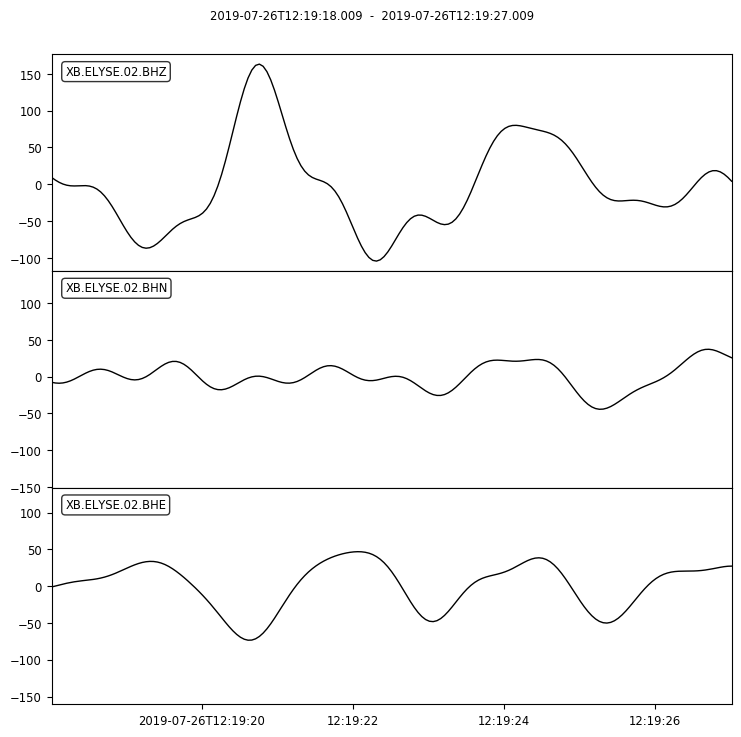

In [4]:
#filter to highlight P-wave energy
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stf.plot();

#trim to P-wave energy (using particle motion timewindow)
stP = stf.slice(starttime=begin-1,endtime=begin+8)
stP.plot();

In [5]:
def rotate(c1,c2,a):
    """
    IN: c1,c2 (arrays) and a (angle)
    c1 c2 are the X and Y axes, respectively of a Cartesian coordinate system
    a is an angle in degrees, positive angle means a clockwise rotation of the coordinate system.
    OUT: o1, o2 (arrays)
    o1 o2 are the X and Y axes, respectively of a rotated Cartesian coordinate system
    """
    o1 = np.cos(np.radians(a))*c1 - np.sin(np.radians(a))*c2
    o2 = np.sin(np.radians(a))*c1 + np.cos(np.radians(a))*c2
    return o1, o2

In [6]:
num = 0
for tr in stP:
    print(str(num) + tr.id)
    num = num + 1

0XB.ELYSE.02.BHE
1XB.ELYSE.02.BHN
2XB.ELYSE.02.BHZ


In [7]:
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_74 = tval[np.where(alpha == 74)]
print(mina_74, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported as 74

[ 0.77199927] [ 0.6871662]
optimal angle =  66  or  -114


Text(68, 8, '$\\theta_t$ = 66$\\degree$')

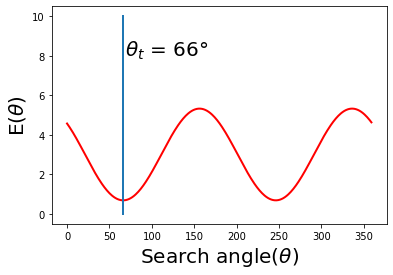

In [8]:
plt.plot(alpha, tval, 'r-', linewidth=2)
plt.xlabel('Search angle'+r'($\theta$)', fontsize=20)
plt.ylabel(r'E($\theta$)', fontsize = 20)

# Add a vertical line at the point of minimum energy
plt.plot([mina,mina],[0,10],linewidth = 2)
plt.text(mina+2,8,r'$\theta_t$ = '+ thetat +r'$\degree$', fontsize=20)

1.02543902227
[0.058493736473024124, 0.25653718178038198, 0.34171874087257681, 0.61993728962260541, 0.69115324890427399, 0.70482793362370033, 0.66957845291951557, 0.97774961448787634, 1.058925424159497, 1.7286073688290178, 1.7974368687014566, 1.7304106732802933, 1.7758207577060845, 1.9449490204275413]
4.86154533039e-05


(array([ 1.,  2.,  1.,  3.,  1.,  1.,  0.,  0.,  2.,  3.]),
 array([ 0.05849374,  0.24713926,  0.43578479,  0.62443032,  0.81307585,
         1.00172138,  1.19036691,  1.37901244,  1.56765796,  1.75630349,
         1.94494902]),
 <a list of 10 Patch objects>)

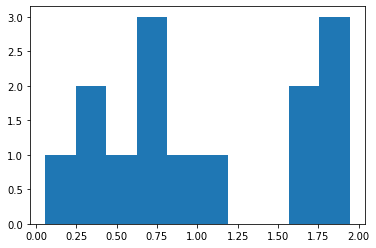

In [9]:
#plotting the error / noise on a histogram

noise_energy = []
var = []

#need to loop over different noise bins?
for i in range(1,15):
    noise = stf.slice(starttime=begin-(i*14),endtime=begin-(i*4))

    hhe_n = scale * noise[0].data
    hhn_n = scale * noise[1].data

    tvall_n = []
    alpha = np.arange(0,360,1)

    # calculate Energy on channels oriented in the a direction, for all a in alpha:
    # angle a is relative to orientation of channels 1 and 2.
    # c1 is the x-axis, c2 is the y-axis
    for a in alpha:
        hhT,hhR = rotate(hhe_n,hhn_n,a)
        Tenergy = np.dot(hhT,hhT)
        variance = Tenergy/200
        var.append(variance)
        tvall_n.append(Tenergy)
    

    tval_n = np.array(tvall_n) 
    min_ind = np.argmin(tval_n)
    noise_energy.append(tval_n[min_ind])

mean = np.mean(noise_energy)
print(mean)
print(noise_energy)
print(np.var(var))
plt.hist(noise_energy, bins=10)

Text(68, 8, '$\\theta_t$ = 66$\\degree$')

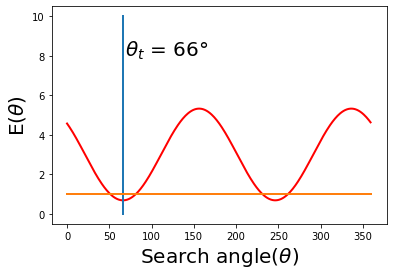

In [10]:
plt.plot(alpha, tval, 'r-', linewidth=2)
plt.xlabel('Search angle'+r'($\theta$)', fontsize=20)
plt.ylabel(r'E($\theta$)', fontsize = 20)

# Add a vertical line at the point of minimum energy
plt.plot([mina,mina],[0,10],linewidth = 2)
plt.plot([0,360],[mean, mean],linewidth = 2)
plt.text(mina+2,8,r'$\theta_t$ = '+ thetat +r'$\degree$', fontsize=20)

Text(0, 0.5, 'E($\\theta$)')

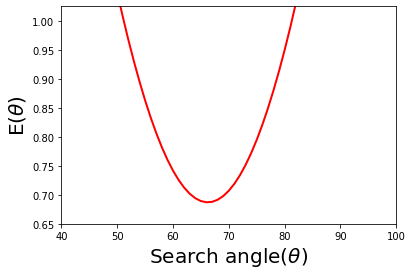

In [11]:
plt.plot(alpha, tval, 'r-', linewidth=2)
plt.ylim(0.65,mean)
plt.xlim(40,100)
plt.xlabel('Search angle'+r'($\theta$)', fontsize=20)
plt.ylabel(r'E($\theta$)', fontsize = 20)

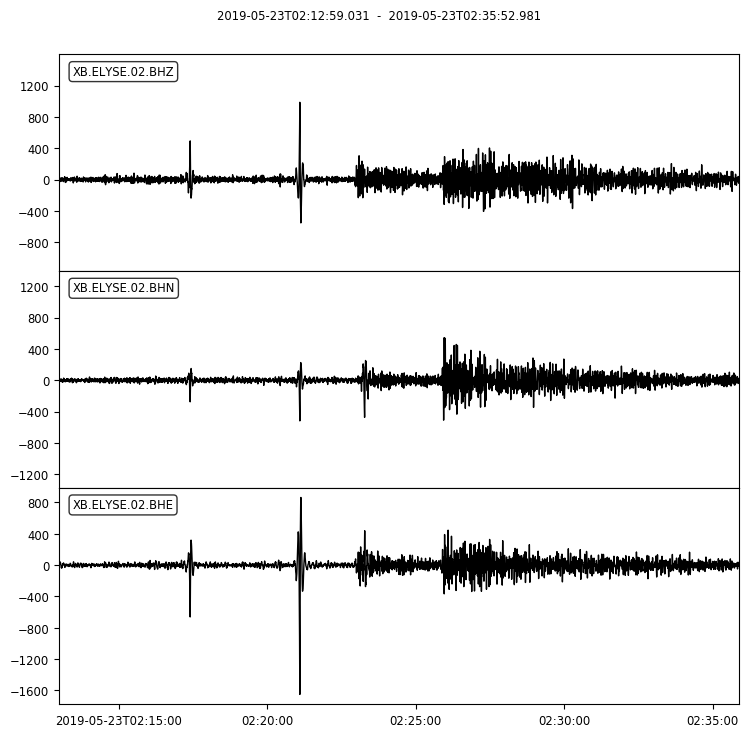

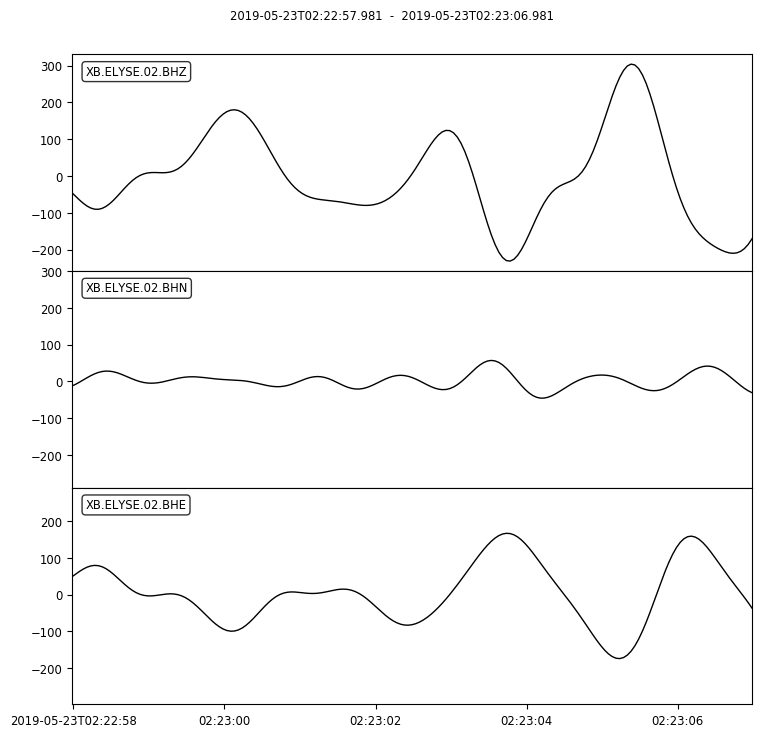

0XB.ELYSE.02.BHE
1XB.ELYSE.02.BHN
2XB.ELYSE.02.BHZ


In [12]:
#import data from S0173a
scale = 1/400
begin = UTCDateTime('2019-05-23T02:22:59')  # p-wave arrival
end = UTCDateTime('2019-05-23T02:25:53')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

#filter to highlight P-wave energy
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stf.plot();

#trim to P-wave energy (using particle motion timewindow)
stP = stf.slice(starttime=begin-1,endtime=begin+8)
stP.plot();

num = 0
for tr in stP:
    print(str(num) + tr.id)
    num = num + 1

In [13]:
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
mina_91 = tval[np.where(alpha == 91)]
print(mina_91, mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

#reported 91 degrees

[ 0.49613583] [ 0.44164387]
optimal angle =  86  or  -94


0.214669577331


(array([ 4.,  0.,  2.,  0.,  1.,  1.,  4.,  0.,  0.,  1.]),
 array([ 0.11771145,  0.14243699,  0.16716253,  0.19188808,  0.21661362,
         0.24133916,  0.2660647 ,  0.29079024,  0.31551578,  0.34024132,
         0.36496687]),
 <a list of 10 Patch objects>)

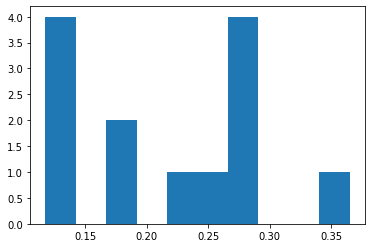

In [14]:
#plotting the error / noise on a histogram

noise_energy = []

#need to loop over different noise bins?

noise_bins = [
    '2019-05-23T02:19:00',
    '2019-05-23T02:19:20',
    '2019-05-23T02:19:30',
    '2019-05-23T02:19:40',
    '2019-05-23T02:19:50',
    '2019-05-23T02:20:00',
    '2019-05-23T02:15:00',
    '2019-05-23T02:15:10',
    '2019-05-23T02:15:20',
    '2019-05-23T02:15:30',
    '2019-05-23T02:15:40',
    '2019-05-23T02:15:50',
    '2019-05-23T02:16:00'
]
for t in noise_bins:
    begin = UTCDateTime(t)
    noise = stf.slice(starttime=begin,endtime=begin+10)

    hhe_n = scale * noise[0].data
    hhn_n = scale * noise[1].data

    tvall_n = []
    alpha = np.arange(0,360,1)

    # calculate Energy on channels oriented in the a direction, for all a in alpha:
    # angle a is relative to orientation of channels 1 and 2.
    # c1 is the x-axis, c2 is the y-axis
    for a in alpha:
        hhT,hhR = rotate(hhe_n,hhn_n,a)
        Tenergy = np.dot(hhT,hhT)
        tvall_n.append(Tenergy)
    

    tval_n = np.array(tvall_n) 
    min_ind = np.argmin(tval_n)
    noise_energy.append(tval_n[min_ind])

mean = np.mean(noise_energy)
print(mean)
plt.hist(noise_energy, bins=10)

Text(88, 7, '$\\theta_t$ = 86$\\degree$')

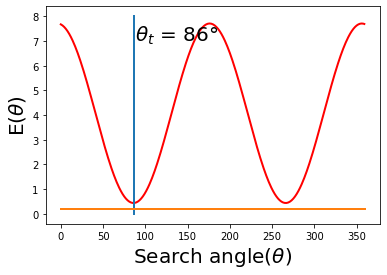

In [15]:
plt.plot(alpha, tval, 'r-', linewidth=2)
plt.xlabel('Search angle'+r'($\theta$)', fontsize=20)
plt.ylabel(r'E($\theta$)', fontsize = 20)

# Add a vertical line at the point of minimum energy
plt.plot([mina,mina],[0,8],linewidth = 2)
plt.plot([0,360],[mean, mean],linewidth = 2)
plt.text(mina+2,7,r'$\theta_t$ = '+ thetat +r'$\degree$', fontsize=20)

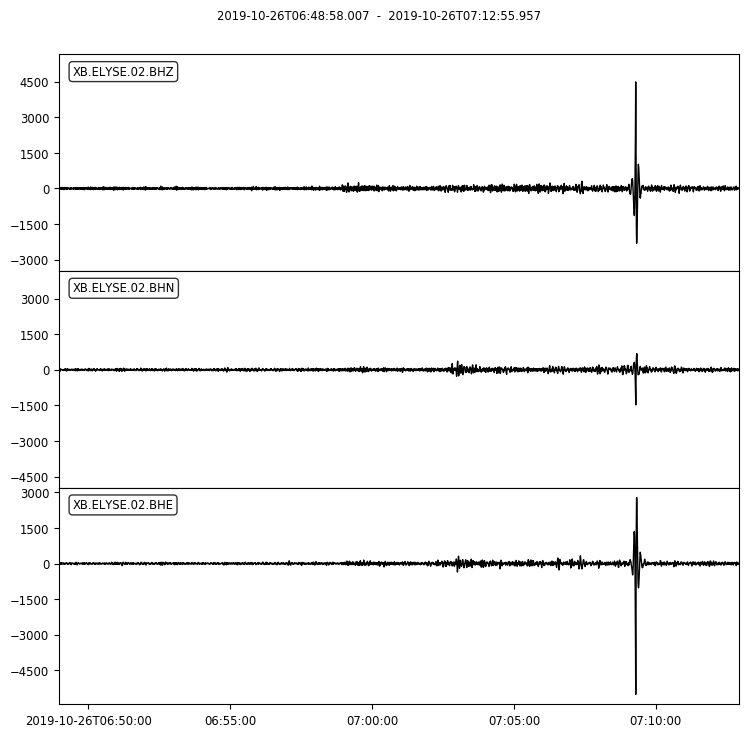

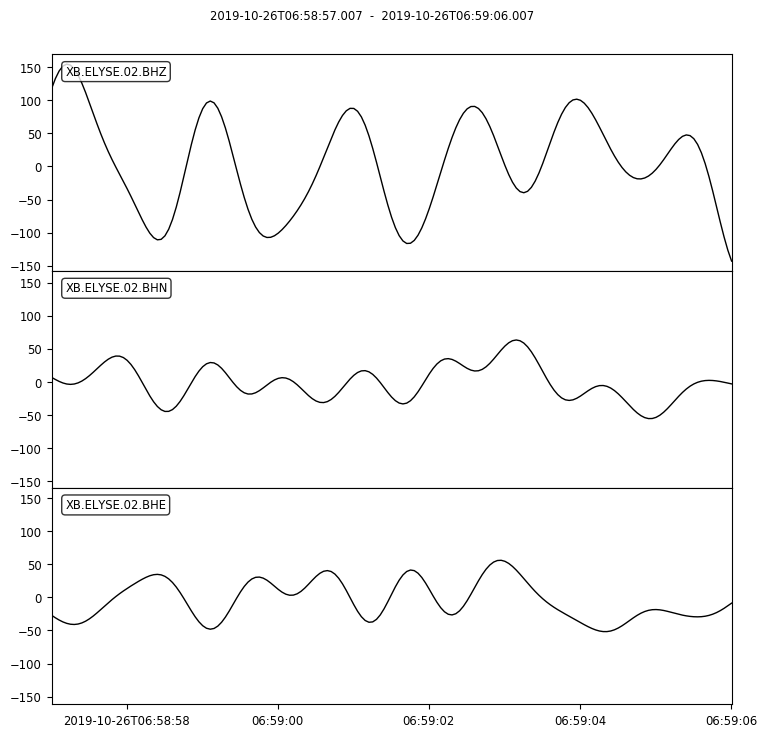

0XB.ELYSE.02.BHE
1XB.ELYSE.02.BHN
2XB.ELYSE.02.BHZ


In [16]:
#import data from S0325aa
scale = 1/200
begin = UTCDateTime('2019-10-26T06:58:58')  # p-wave arrival
end = UTCDateTime('2019-10-26T07:02:56')    # s-wave arrival

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

#filter to highlight P-wave energy
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)
stf.plot();

#trim to P-wave energy (using particle motion timewindow)
stP = stf.slice(starttime=begin-1,endtime=begin+8)
stP.plot();

num = 0
for tr in stP:
    print(str(num) + tr.id)
    num = num + 1

In [17]:
hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)

[ 3.04786848]
optimal angle =  70  or  -110


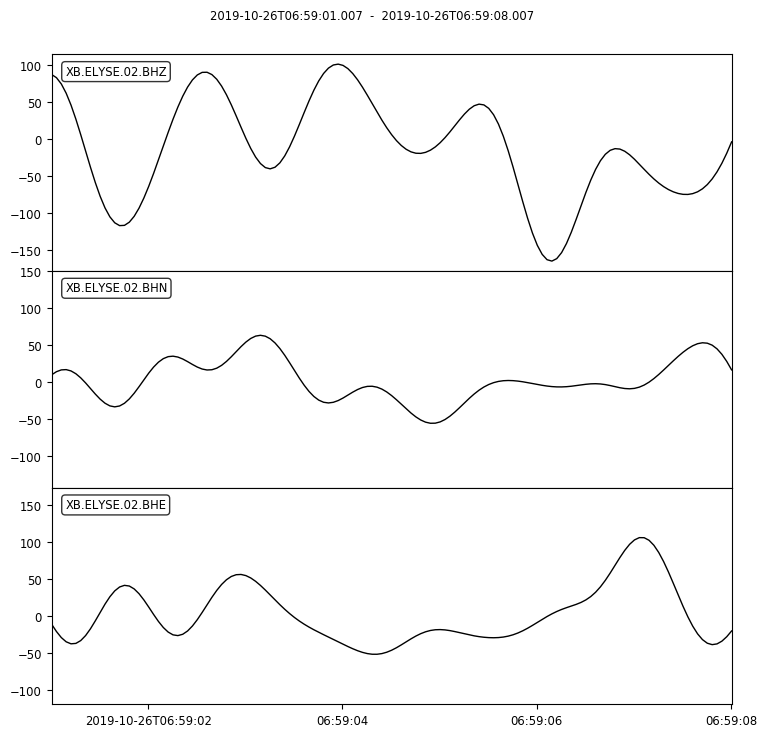

[ 2.63444626]
optimal angle =  74  or  -106


In [21]:
scale = 1/200
begin = UTCDateTime('2019-10-26T06:58:58')  # p-wave arrival 325a
end = UTCDateTime('2019-10-26T07:02:56')    # s-wave arrival 325a

#begin = UTCDateTime('2019-07-26T12:19:19')  # p-wave arrival 235b
#end = UTCDateTime('2019-07-26T12:22:05')    # s-wave arrival 235b

st_uvw = waveforms(begin, end, 600)
st_z12 = uvw2enz(st_uvw)

#filter to highlight P-wave energy
stf = st_z12.copy()
stf.filter('bandpass', freqmin = 0.125, freqmax = 1.0, corners=4, zerophase=True)

#trim to P-wave energy (using particle motion timewindow)
stP = stf.slice(starttime=begin+3,endtime=begin+10)
stP.plot();

hhe = scale * stP[0].data
hhn = scale * stP[1].data

tvall = []
alpha = np.arange(0,360,1)

# calculate Energy on channels oriented in the a direction, for all a in alpha:
# angle a is relative to orientation of channels 1 and 2.
# c1 is the x-axis, c2 is the y-axis
for a in alpha:
    hhT,hhR = rotate(hhe,hhn,a)
    Tenergy = np.dot(hhT,hhT)
    tvall.append(Tenergy)
    
tval = np.array(tvall) 
mina = alpha[np.argmin(tval)]

mina_guess = tval[np.where(alpha == mina)]
print(mina_guess)

#angle at which the energy is minimized
print('optimal angle = ',mina,' or ',mina-180)
thetat = str(mina); thetalt = str(mina-180)